#### PROJECT GOAL: THE GOAL OF THE PROJECT IS TO TEST THE DEGREE OF EFFECTIVENESS OF SELECTED MACHINE LEARNING MODELS/ALGORITHMS TO PREDICT THE VALUE OF TIME SERIES DATA BASED ON THE GOOGLE/ALPHABET STOCK

#### I CHOSE THIS COMPANY BECAUSE IT IS THE WORLD LARGEST TECH COMPANY AND I PERSONALLY OWN IT IN MY INVESTMENT PORTFOLIO

In [ ]:
pip install yfinance

In [2]:
import yfinance as yf

import pandas as pd
from pandas.plotting import autocorrelation_plot

import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from sklearn import linear_model
from sklearn import  metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

C:\Users\Krzysiek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Krzysiek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


#### DATA IMPORT USING YFINANCE

In [3]:
data = yf.download('GOOGL', index_col = 0, squeeze = True, parse_dates=['Date'])

[*********************100%***********************]  1 of 1 completed


#### DATA PRINT

In [4]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.502503,2.604104,2.401401,2.511011,2.511011,893181924
2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044
...,...,...,...,...,...,...
2023-01-30,97.480003,98.290001,96.400002,96.940002,96.940002,27226200
2023-01-31,96.870003,98.879997,96.820000,98.839996,98.839996,29870700
2023-02-01,98.709999,101.190002,97.580002,100.430000,100.430000,35531100


#### CONCLUSION: COLUMNS IN IMPORTED DATA REPRESENT RESPECTIVELY: OPENING PRICE IN THE SESSION, MAXIMUM PRICE DURING THE SESSION, MINIMUM PRICE IN THE SESSION, CLOSING PRICE IN THE SESSION AND TRADING VOLUME, ROWS/INDEXES REPRESENT TRADING DAY

#### DATA DIMENSIONS PRINT

In [5]:
data.shape

(4648, 6)

#### CHECKING IF THERE ARE MISSING VALUES IN THE DATA

In [6]:
data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

#### CONCLUSION: IMPORTED DATA IS CLEAN - NO MISSING VALUES PRESENT

#### FILTERING ANALYZED DATA - WE ARE INTERESTED IN THE CLOSING PRICE

In [7]:
data = data['Close']

#### PLOTTING CHART OF THE CLOSING PRICE OVER TIME

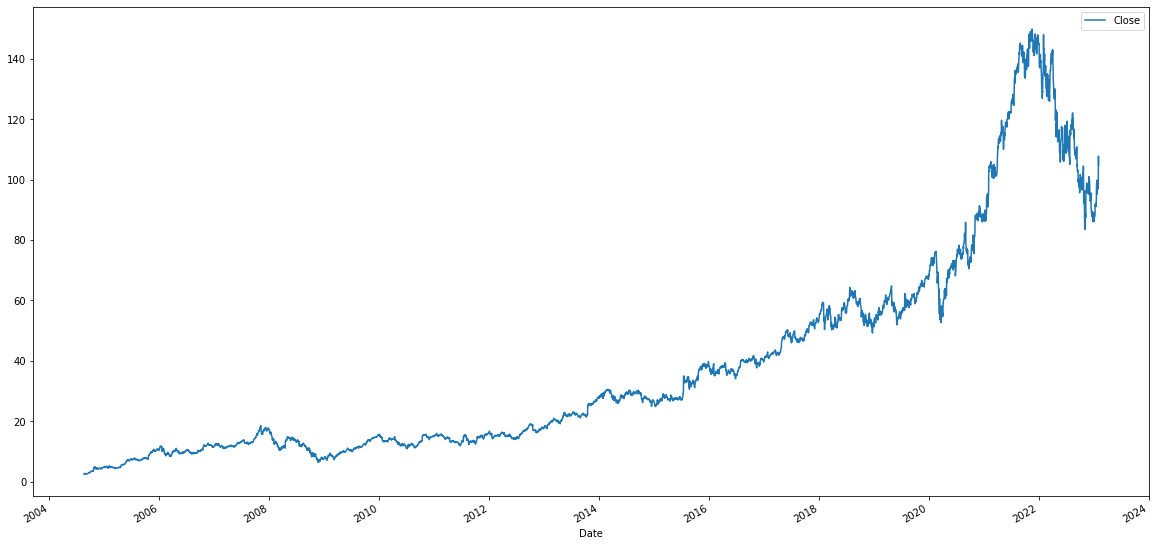

In [8]:
plt.figure(figsize=(20, 10))

data.plot()

plt.legend(loc='best')
plt.show()

#### DEFINING FUNCTION TEST_STATIONARITY TO CHECK STATIONARITY OF TIME-SERIES DATA

In [9]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()#.rolling_mean(timeseries, window=12)
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(20,10));
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#### TIME-SERIES DATA STATIONARITY CHECK

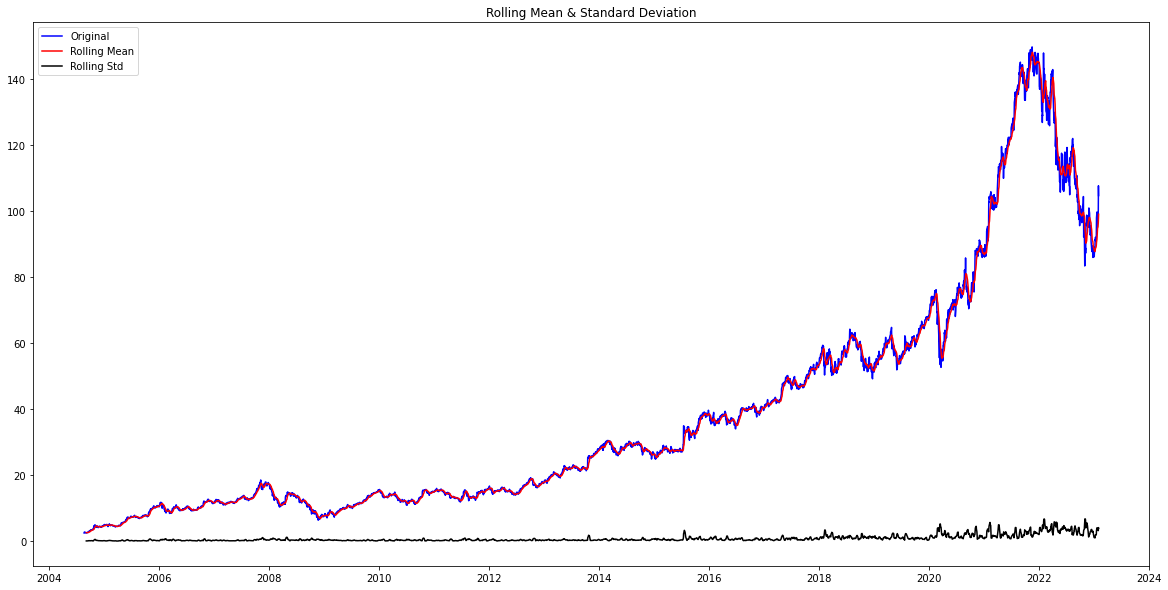

Results of Dickey-Fuller Test:
Test Statistic                    0.081175
p-value                           0.964752
#Lags Used                       23.000000
Number of Observations Used    4624.000000
Critical Value (1%)              -3.431765
Critical Value (5%)              -2.862165
Critical Value (10%)             -2.567103
dtype: float64


In [10]:
test_stationarity(data)

#### P-VALUE CHECK

In [11]:
_,pval,_,_,_,_ =adfuller(data, autolag='AIC')
pval

0.9647520460228468

#### P-VALUE CHECK

In [12]:
if pval > 0.05:
    print('pval > 0.05 -> ZERO HYPOTHESIS TRUE -> TIME-SERIES DATA IS NOT STATIONARY')
else:
    print('pval < = 0.05 -> ZERO HYPOTHESIS FALSE -> TIME-SERIES DATA IS STATIONARY')

pval > 0.05 -> ZERO HYPOTHESIS TRUE -> TIME-SERIES DATA IS NOT STATIONARY


#### AUTO-CORRELATION CHECK

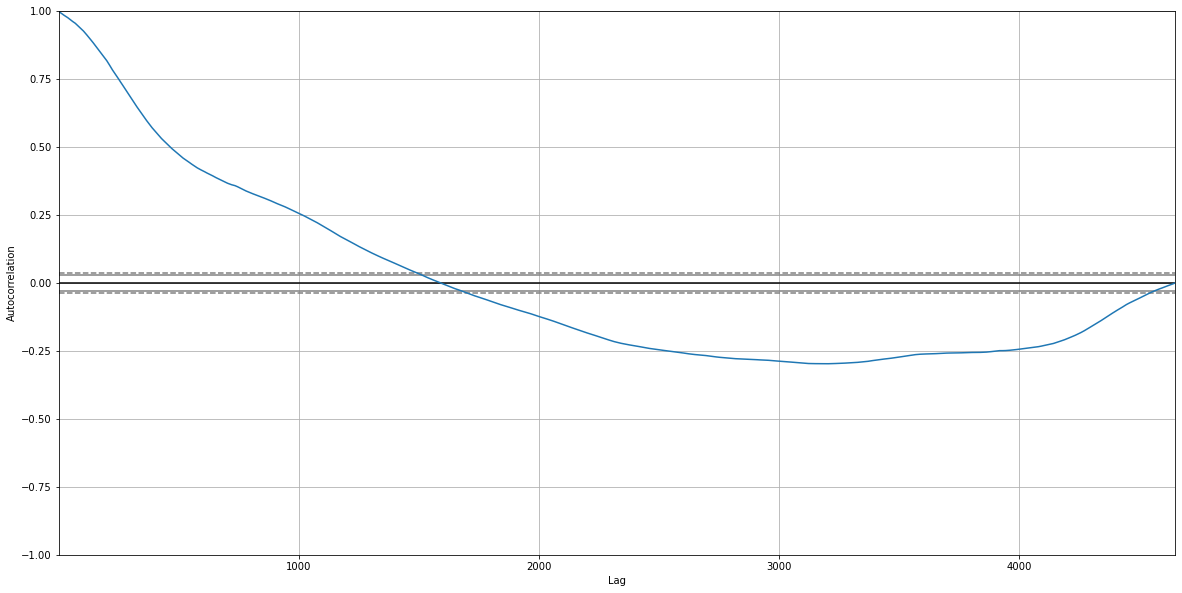

In [13]:
plt.figure(figsize=(20,10))

autocorrelation_plot(data)

plt.show()

#### AUTO-CORRELATION CHECK

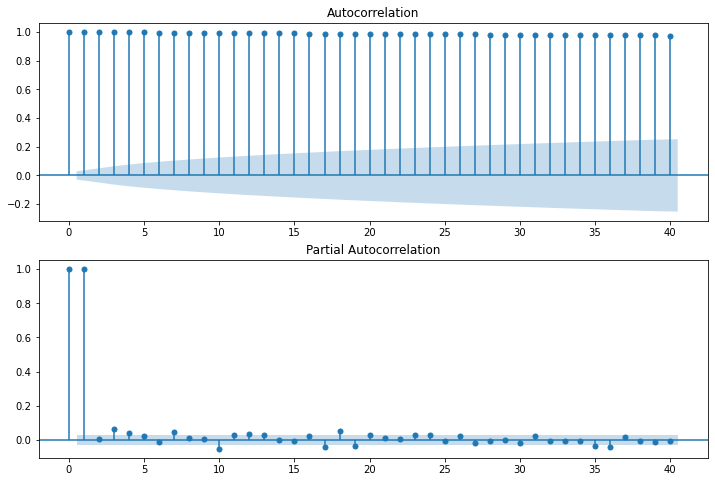

In [14]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.values, lags=40, ax=ax2)

plt.show()

#### DEFINING SIZE OF TEST DATA SECTION

In [15]:
test_size = 0.2

#### DATA TRANSFORMATION FOR LSTM NEURAL NETWORK PURPOSES

In [16]:
data_lstm = data.values.reshape(-1,1)

#### TRAIN-TEST DATA SPLIT

In [17]:
training_data_size = int(len(data_lstm)*(1-test_size))
test_data_size = len(data_lstm)-training_data_size

#### TRAIN-TEST DATA SPLIT

In [18]:
train_data = data_lstm[0:training_data_size,:]
test_data = data_lstm[training_data_size:len(data_lstm),:1]

#### TRANSFORMING DIVIDED DATA TO FEED LSTM NEURAL NETWORK

In [19]:
scaler = MinMaxScaler()

train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

#### DEFINING THE TIME_STEP PARAMETER I.E. THE NUMBER OF PAST OBSERVATIONS BASED ON WHICH WE WILL TRY TO PREDICT THE NEXT OBSERVATION

In [20]:
time_step = 5

#### DEFINING CREATE_DATASET FUNCTION

In [21]:
def create_dataset(dataset, time_step=time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

X_train, y_train = create_dataset(train_data_scaled, time_step)
X_test, y_test = create_dataset(test_data_scaled, time_step)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

#### DEFINING LSTM NEURAL NETWORK MODEL

In [22]:
model_lstm=Sequential()
model_lstm.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50,return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mean_squared_error', optimizer ='adam', metrics=['mse', 'mae'])

model_lstm.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
223/223 [==============================] - 12s 18ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0450 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0379
Epoch 2/30
223/223 [==============================] - 2s 11ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0228 - val_loss: 8.0614e-04 - val_mse: 8.0614e-04 - val_mae: 0.0236
Epoch 3/30
223/223 [==============================] - 3s 11ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0221 - val_loss: 9.8180e-04 - val_mse: 9.8180e-04 - val_mae: 0.0264
Epoch 4/30
223/223 [==============================] - 3s 13ms/step - loss: 9.0637e-04 - mse: 9.0637e-04 - mae: 0.0208 - val_loss: 7.1303e-04 - val_mse: 7.1303e-04 - val_mae: 0.0219
Epoch 5/30
223/223 [==============================] - 3s 15ms/step - loss: 7.3765e-04 - mse: 7.3765e-04 - mae: 0.0183 - val_loss: 8.1835e-04 - val_mse: 8.1835e-04 - val_mae: 0.0238
Epoch 6/30
223/223 [==============================] - 3s 13ms/step - loss: 8.0034e-04 - mse: 8.0034e-04 - mae: 0.0193 - val_lo

#### DATA PREDICTION WITH LSTM NEURAL NETWORK MODEL FOR TRAINING AND TEST DATA

In [23]:
train_predict = model_lstm.predict(X_train)
test_predict = model_lstm.predict(X_test)

29/29 [==============================] - 1s 5ms/step


#### TRANSFORMATION OF DATA FOR CORRECT PLOTTING

In [24]:
train_predict_inverted = scaler.inverse_transform(train_predict)
test_predict_inverted = scaler.inverse_transform(test_predict)

train_predict_inverted_zeros = np.zeros(time_step+1)
train_predict_inverted_final = np.insert(train_predict_inverted, 0, train_predict_inverted_zeros)

test_predict_inverted_zeros = np.zeros(train_predict_inverted_final.shape[0]+ time_step+1)
test_predict_inverted_final= np.insert(test_predict_inverted, 0, test_predict_inverted_zeros)

#### PLOTTING IMPORTED DATA AND PREDICTIONS USING LSTM NEURAL NETWORK MODEL FOR TRAINING AND TEST DATA SECTIONS

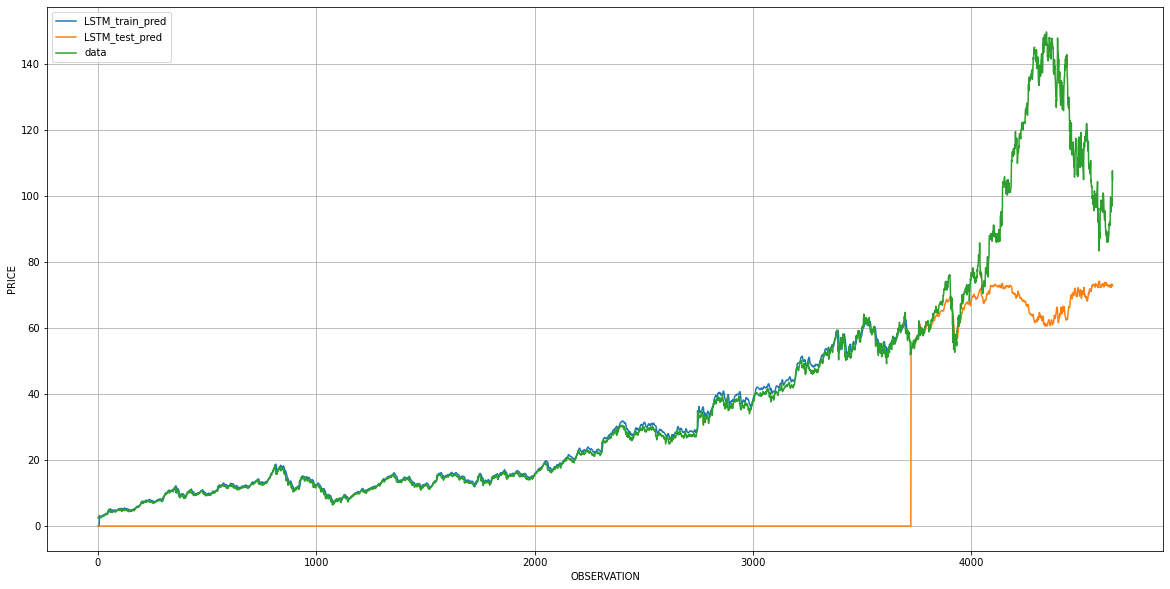

In [25]:
plt.figure(figsize=(20,10))

plt.plot(train_predict_inverted_final, label='LSTM_train_pred')
plt.plot(test_predict_inverted_final, label = 'LSTM_test_pred')
plt.plot(data.values, label= 'data')

plt.legend(loc='best')
plt.grid()
plt.xlabel('OBSERVATION')
plt.ylabel('PRICE')
plt.show()

#### CALCULATION OF QUALITY METRICS FOR PREDICTED VALUES FROM TEST DATA SECTION FOR LSTM NEURAL NETWORK MODEL

In [26]:
lstm_mean_squared_error = metrics.mean_squared_error(test_predict_inverted, data.values[-test_data_size+time_step+1:])

lstm_mean_absolute_error = metrics.mean_absolute_error(test_predict_inverted, data.values[-test_data_size+time_step+1:])

lstm_median_absolute_error = metrics.median_absolute_error(test_predict_inverted, data.values[-test_data_size+time_step+1:])

lstm_explained_variance_score = metrics.explained_variance_score(test_predict_inverted, data.values[-test_data_size+time_step+1:])

lstm_r2 = metrics.r2_score(test_predict_inverted, data.values[-test_data_size+time_step+1:])

#### CREATION AND ON-SCREEN PRINTING OF DATAFRAME WITH QUALITY METRICS FOR LSTM NEURAL NETWORK MODEL

In [27]:
d_1 = {'r2': [lstm_r2],
     'explained_variance_score': [lstm_explained_variance_score], 
     'median_absolute_error': [lstm_median_absolute_error],
     'mean_squared_error' : [lstm_mean_squared_error],
     'mean_absolute_error' : [lstm_mean_absolute_error],
    }

df_1 = pd.DataFrame(data=d_1)
df_1.insert(loc=0, column='Method', value=['LSTM'])

df_1

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
0,LSTM,-68.926651,-31.767832,22.857452,1724.690746,30.507345


In [135]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [136]:
df_train = df[:training_data_size]

df_train

,t
0,2.511011
1,2.710460
2,2.737738
3,2.624374
4,2.652653
...,...
3713,57.722000
3714,57.792500
3715,57.266998
3716,56.930500


In [137]:
df_train[-10:]

,t
3708,56.243000
3709,58.540001
3710,59.224998
3711,58.438999
3712,57.233002
3713,57.722000
3714,57.792500
3715,57.266998
3716,56.930500
3717,56.978001


In [138]:
df = pd.DataFrame()
df['t'] = [x for x in data]

dataframe = series_to_supervised(df_train, time_step, 1)

dataframe

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
5,2.511011,2.710460,2.737738,2.624374,2.652653,2.700450
6,2.710460,2.737738,2.624374,2.652653,2.700450,2.656406
7,2.737738,2.624374,2.652653,2.700450,2.656406,2.552803
8,2.624374,2.652653,2.700450,2.656406,2.552803,2.561812
9,2.652653,2.700450,2.656406,2.552803,2.561812,2.508759
...,...,...,...,...,...,...
3713,56.243000,58.540001,59.224998,58.438999,57.233002,57.722000
3714,58.540001,59.224998,58.438999,57.233002,57.722000,57.792500
3715,59.224998,58.438999,57.233002,57.722000,57.792500,57.266998
3716,58.438999,57.233002,57.722000,57.792500,57.266998,56.930500


In [139]:
array = dataframe_real.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]

In [140]:
seed=123
kfold = model_selection.KFold(n_splits=5, random_state=None)

In [141]:
grid_1 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=1, max_iter=1000, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'elasticnet__alpha': [1, 2, 3]},
                    cv=kfold,
                    refit=True)

grid_1.fit(X, y)
grid_1.best_params_

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.43469483051422, tolerance: 72.50758803630818
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.90699255614743, tolerance: 80.89949030160558
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149.8589440856424, tolerance: 87.1204517008859
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2564.832414316628, tolerance: 87.1204517008859
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2533.70908586204, tolerance: 87.28717102774287
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1144.3205149283735, tolerance: 22.334538405070962
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conve

{'elasticnet__alpha': 1, 'polynomialfeatures__degree': 1}

In [473]:
X[-1:]

array([[57.23300171, 57.72200012, 57.79249954, 57.26699829, 56.93050003]])

In [474]:
X

array([[ 2.51101089,  2.71045995,  2.73773789,  2.62437391,  2.65265298],
       [ 2.71045995,  2.73773789,  2.62437391,  2.65265298,  2.70044994],
       [ 2.73773789,  2.62437391,  2.65265298,  2.70044994,  2.65640593],
       ...,
       [59.22499847, 58.43899918, 57.23300171, 57.72200012, 57.79249954],
       [58.43899918, 57.23300171, 57.72200012, 57.79249954, 57.26699829],
       [57.23300171, 57.72200012, 57.79249954, 57.26699829, 56.93050003]])

In [475]:
test = X[-1:].reshape(1, -1)

test

array([[57.23300171, 57.72200012, 57.79249954, 57.26699829, 56.93050003]])

In [476]:
predicted= grid_1.predict(test)

In [477]:
predicted

array([57.18902649])

In [478]:
test_list = []

In [479]:
test_list.append(predicted)

In [480]:
test_list

[array([57.18902649])]

In [481]:
X[-1:]

array([[57.23300171, 57.72200012, 57.79249954, 57.26699829, 56.93050003]])

In [482]:
#elo = X[-1:].tolist()

elo = X[-1:]


In [483]:
np.ndarray.flatten(elo)

array([57.23300171, 57.72200012, 57.79249954, 57.26699829, 56.93050003])

In [503]:
X[-1:].tolist()[0]

[57.233001708984375,
 57.72200012207031,
 57.79249954223633,
 57.266998291015625,
 56.93050003051758]

In [545]:
future_observations = 2
test_list = []

test_predictor = X[-1:].reshape(1,-1)

training_predictor = X[-1:].tolist()[0]

predictors = []

for predictor in training_predictor:
    
    predictors.append(predictor)
    
print('Predyktory z czesci treningowej: {}' .format(predictors))
         
for i in range(future_observations):
       
    test_val= grid_1.predict(test_predictor)
    
    test_val_clean = test_val.item()
    
    print('Predykcja z predyktorow: {}' .format(test_val_clean))
        
    test_list.append(test_val_clean)
    
    print('Obliczone predykcje do danych testowych: {}'.format(test_list))
    
    predictors.append(test_val_clean)
    
    del predictors[0]
    
    print('Nowe predyktory do tworzenia danych testowych: {}' .format(predictors))
    
    test_predictor = np.array(predictors).reshape(1,-1)

Predyktory z czesci treningowej: [57.233001708984375, 57.72200012207031, 57.79249954223633, 57.266998291015625, 56.93050003051758]
Predykcja z predyktorow: 57.18902648866798
Obliczone predykcje do danych testowych: [57.18902648866798]
Nowe predyktory do tworzenia danych testowych: [57.72200012207031, 57.79249954223633, 57.266998291015625, 56.93050003051758, 57.18902648866798]
Predykcja z predyktorow: 57.137861455682994
Obliczone predykcje do danych testowych: [57.18902648866798, 57.137861455682994]
Nowe predyktory do tworzenia danych testowych: [57.79249954223633, 57.266998291015625, 56.93050003051758, 57.18902648866798, 57.137861455682994]


In [563]:
future_observations = 2
test_list = []
predictors = []

test_predictor = X[-1:].reshape(1,-1)
training_predictor = X[-1:].tolist()[0]

for predictor in training_predictor:
    
    predictors.append(predictor)
    
print('Predyktory z czesci treningowej: {}' .format(predictors))
         
for i in range(test_data_size):
       
    test_val= grid_1.predict(test_predictor)
    
    test_val_clean = test_val.item()
        
    test_list.append(test_val_clean)
      
    predictors.append(test_val_clean)
    
    del predictors[0]
    
    test_predictor = np.array(predictors).reshape(1,-1)
    
test_list_array = np.array(test_list)

print('Obliczone predykcje do danych testowych: {}'.format(test_list_array))

Predyktory z czesci treningowej: [57.233001708984375, 57.72200012207031, 57.79249954223633, 57.266998291015625, 56.93050003051758]
Obliczone predykcje do danych testowych: [57.18902649 57.13786146 57.10294325 57.07769412 57.05301587 57.03410071
 57.0104229  56.98754557 56.96496038 56.94231786 56.91975814 56.89716217
 56.87460915 56.85208451 56.82958217 56.80710562 56.78465327 56.76222609
 56.73982377 56.71744621 56.69509346 56.67276545 56.65046219 56.62818362
 56.60592973 56.5837005  56.56149588 56.53931586 56.51716041 56.49502949
 56.47292309 56.45084118 56.42878373 56.4067507  56.38474208 56.36275784
 56.34079795 56.31886239 56.29695112 56.27506412 56.25320136 56.23136282
 56.20954847 56.18775828 56.16599223 56.14425028 56.12253242 56.10083861
 56.07916884 56.05752306 56.03590126 56.01430341 55.99272949 55.97117945
 55.94965329 55.92815098 55.90667247 55.88521776 55.86378682 55.84237961
 55.82099611 55.7996363  55.77830015 55.75698763 55.73569872 55.71443338
 55.69319161 55.67197336 

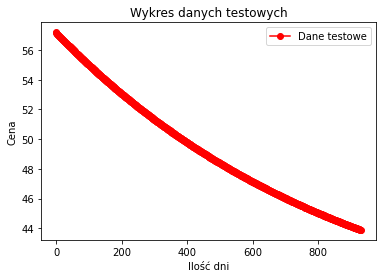

In [566]:
x = np.array(range(0, len(test_list_array)))
y = test_list_array
plt.title("Wykres danych testowych")
plt.xlabel("Ilość dni")
plt.ylabel("Cena")
plt.plot(x, y, color = "red", marker = "o", label = "Dane testowe")
plt.legend()
plt.show()

#### DEFINING SERIES_TO_SUPERVISED FUNCTION

In [70]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### DEFINING RANGE FOR TRAIN-TEST DATA 

In [71]:
data_values = data.values

data_train = data[:-test_data_size]
data_test = data[-test_data_size:]

#### PLOTTING CHART OF TRAIN AND TEST DATA BEFORE THE TRANSFORMATION

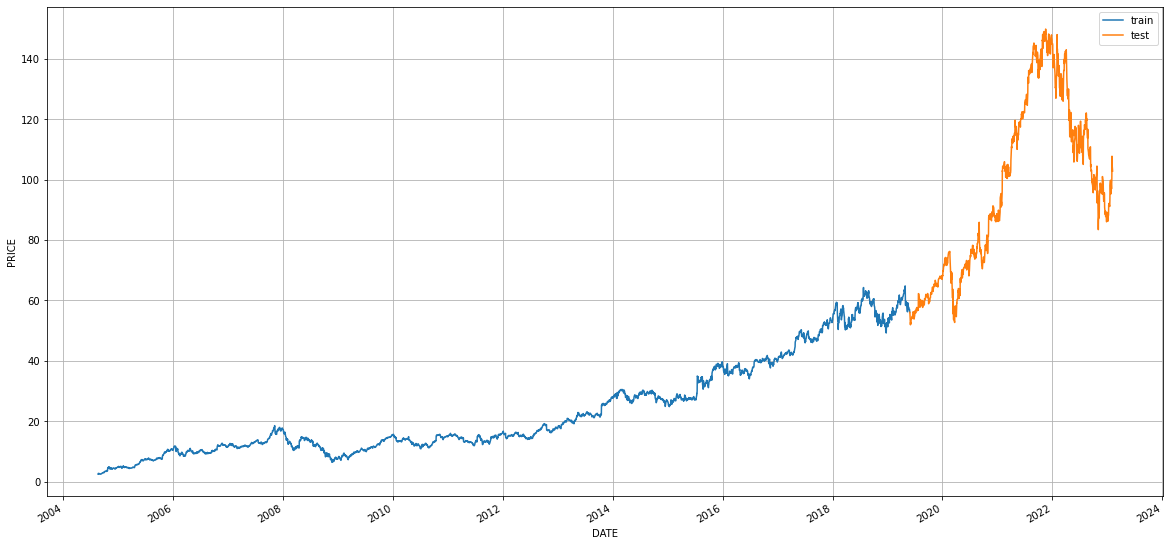

In [72]:
plt.figure(figsize=(20, 10))

data_train.plot(label = 'train')
data_test.plot(label = 'test')

plt.legend(loc='best')
plt.grid()
plt.xlabel('DATE')
plt.ylabel('PRICE')
plt.show()

#### TRANSFORMING AND PRINTING IMPORTED TIME-SERIES DATA USING PREVIOUSLY DEFINED FUNCTION SERIES_TO_SUPERVISED

In [30]:
df = pd.DataFrame()
df['t'] = [x for x in data]

dataframe = series_to_supervised(df, time_step)

dataframe

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
5,2.511011,2.710460,2.737738,2.624374,2.652653,2.700450
6,2.710460,2.737738,2.624374,2.652653,2.700450,2.656406
7,2.737738,2.624374,2.652653,2.700450,2.656406,2.552803
8,2.624374,2.652653,2.700450,2.656406,2.552803,2.561812
9,2.652653,2.700450,2.656406,2.552803,2.561812,2.508759
...,...,...,...,...,...,...
4643,99.790001,97.699997,95.220001,97.519997,99.370003,96.940002
4644,97.699997,95.220001,97.519997,99.370003,96.940002,98.839996
4645,95.220001,97.519997,99.370003,96.940002,98.839996,100.430000
4646,97.519997,99.370003,96.940002,98.839996,100.430000,107.739998


In [37]:
array = dataframe.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]

#### TRAIN-TEST DATA SPLIT

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

#### DEFINING CROSS-VALIDATION PARAMETERS TO AVOID OVER-FITTING

In [39]:
seed=123
kfold = model_selection.KFold(n_splits=5, random_state=None)

#### SEARCHING FOR THE OPTIMAL DEGREE OF A POLYNOMIAL USING ELASTIC NET REGRESSION METHOD
#### ANALYZED DEGREES OF POLYNOMIAL: FROM 1 TO 4
#### ANALYZED ALPHA COEFFICIENT: 1, 2, 3
#### RETURN OPTIMAL DEGREE OF POLYNOMIAL

In [40]:
grid_1 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=1, max_iter=1000, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'elasticnet__alpha': [1, 2, 3]},
                    cv=kfold,
                    refit=True)

grid_1.fit(X_train, y_train)
grid_1.best_params_

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.2339793469464, tolerance: 356.9999719913301
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 565.5904079280722, tolerance: 344.7832081101209
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 617.2443962455263, tolerance: 358.239081766105
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conver

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4826.22184921977, tolerance: 362.3167225149916
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4756.860471207403, tolerance: 356.9999719913301
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4717.107449104093, tolerance: 344.7832081101209
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conver

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6010.303039131317, tolerance: 358.239081766105
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6059.308662212159, tolerance: 349.2269413744711
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6171.2704746518375, tolerance: 362.3167225149916
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conve

{'elasticnet__alpha': 1, 'polynomialfeatures__degree': 2}

#### SEARCHING FOR THE OPTIMAL DEGREE OF A POLYNOMIAL USING LASSO REGRESSION METHOD
#### ANALYZED DEGREES OF POLYNOMIAL: FROM 1 TO 4
#### ANALYZED ALPHA COEFFICIENT: 1, 2, 3
#### RETURN OPTIMAL DEGREE OF POLYNOMIAL

In [375]:
grid_2 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=1, max_iter=1000, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'lasso__alpha': [1, 2, 3]},
                    cv=kfold,
                    refit=True)

grid_2.fit(X_train, y_train)
grid_2.best_params_

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 633.7171794134006, tolerance: 360.1192545972787
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 623.8594795899853, tolerance: 350.13390315051936
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 675.3308267531356, tolerance: 362.7618451180465
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6831.358987042276, tolerance: 365.6546028735857
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7298.504905516449, tolerance: 360.1192545972787
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7205.738792371347, tolerance: 350.13390315051936
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9344.53978582926, tolerance: 362.7618451180465
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9369.92859070718, tolerance: 352.54076314346287
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9438.021951928231, tolerance: 365.6546028735857
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conver

{'lasso__alpha': 1, 'polynomialfeatures__degree': 2}

#### SEARCHING FOR THE OPTIMAL DEGREE OF A POLYNOMIAL USING RIDGE REGRESSION METHOD
#### ANALYZED DEGREES OF POLYNOMIAL: FROM 1 TO 4
#### ANALYZED ALPHA COEFFICIENT: 1, 2, 3
#### RETURN OPTIMAL DEGREE OF POLYNOMIAL

In [376]:
grid_3 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1, max_iter=1000, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'ridge__alpha': [1, 2, 3]},
                    cv=kfold,
                    refit=True)

grid_3.fit(X_train, y_train)
grid_3.best_params_

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.66437e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.77844e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.63427e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.73407e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.58827e-17): result may 

{'polynomialfeatures__degree': 1, 'ridge__alpha': 3}

#### SEARCHING FOR THE OPTIMAL DEGREE OF A POLYNOMIAL USING POLYNOMIAL REGRESSION METHOD.
#### ANALYZING DEGREES OF POLYNOMIAL: FROM 1 TO 4
#### RETURN OPTIMAL DEGREE OF POLYNOMIAL

In [377]:
grid_4 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression()),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4]},
                    cv=kfold,
                    refit=True)

grid_4.fit(X_train, y_train)
grid_4.best_params_

{'polynomialfeatures__degree': 1}

#### DEFINING AND TRAINING MLP REGRESSOR NEURAL NETWORK

In [378]:
grid_5 = GridSearchCV(MLPRegressor(hidden_layer_sizes=(100,100,100),activation='tanh',alpha=0.0001,max_iter=1000),
                    param_grid={'hidden_layer_sizes': [(1000,1000,1000),(100,100,100),(10,10,10)],
                                'alpha': [1, 10, 100 ,1000],
                               'activation': ['identity', 'logistic', 'tanh', 'relu']                               
                               },
                    cv = kfold,
                    n_jobs=1,
                    refit=True)

grid_5.fit(X_train,y_train)
grid_5.best_params_

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\ne

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\ne

{'activation': 'relu', 'alpha': 10, 'hidden_layer_sizes': (100, 100, 100)}

#### CREATION LIST OF OPTIMAL R^2, VAR, MAE, MSE PARAMETERS FOR ALL ANALYZED METHODS

In [42]:
models = []
models.append(('ElasticNet', grid_1.best_estimator_))
models.append(('Lasso', grid_2.best_estimator_))
models.append(('Ridge', grid_3.best_estimator_))
models.append(('LR', grid_4.best_estimator_))
models.append(('MLP_R', grid_5.best_estimator_))

r2 = []
explained_variance_score = []
median_absolute_error = []
mean_squared_error = []
mean_absolute_error = []

for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
    print("Explained variance score: {}".format( metrics.explained_variance_score(y_test, model.predict(X_test)) ))
    print("Median absolute error: {}".format( metrics.median_absolute_error(y_test, model.predict(X_test)) ))
    print("Mean squared error: {}".format( metrics.mean_squared_error(y_test, model.predict(X_test)) ))
    print("Mean absolute errors: {}".format(metrics.mean_absolute_error(y_test, model.predict(X_test)) ))
    r2.append(metrics.r2_score(y_test, model.predict(X_test)))
    explained_variance_score.append(metrics.explained_variance_score(y_test, model.predict(X_test)))
    median_absolute_error.append( metrics.median_absolute_error(y_test, model.predict(X_test)))
    mean_squared_error.append(metrics.mean_squared_error(y_test, model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))

print('LSTM')
print("R^2: {}".format(lstm_r2))
print("Explained variance score: {}".format(lstm_explained_variance_score))
print("Median absolute error: {}".format(lstm_median_absolute_error))
print("Mean squared error: {}".format(lstm_mean_absolute_error))
print("Mean absolute errors: {}".format(lstm_mean_absolute_error))

NameError: name 'grid_2' is not defined

#### CREATION AND PRINT OF DATAFRAME INCLUDING R^2, VAR, MAE, MSE PARAMETERS FOR ALLANALYZED METHODS

In [43]:
d_2 = {'r2': r2, 
     'explained_variance_score': explained_variance_score, 
     'median_absolute_error': median_absolute_error,
     'mean_squared_error' : mean_squared_error,
     'mean_absolute_error' : mean_absolute_error,
    }

df_2 = pd.DataFrame(data=d_2)
df_2.insert(loc=0, column='Method', value=['ElasticNet','Lasso','Ridge', 'LR', 'MLP_R'])

df_2

NameError: name 'r2' is not defined

#### PRINTING PREVIOUSLY CREATED DATAFRAME WITH QUALITY METRICS FOR LSTM NEURAL NETWORK

In [44]:
df_1

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
0,LSTM,-51.891519,-20.418697,24.489548,1650.582692,31.365689


#### PRINTING PREVIOUSLY CREATED DATAFRAME WITH QUALITY METRICS FOR THE REST OF ANALYZED MODELS

In [382]:
df_2

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
0,ElasticNet,0.998973,0.998973,0.302843,1.382899,0.640586
1,Lasso,0.998962,0.998962,0.318984,1.398827,0.646726
2,Ridge,0.999160,0.999161,0.202278,1.131436,0.527426
3,LR,0.999160,0.999161,0.202264,1.131481,0.527411


#### MERGING BOTH DATAFRAMES WITH QUALITY METRICS

In [383]:
df = pd.concat([df_1, df_2])

#### PRINTING MERGED DATAFRAME

In [384]:
df

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
0,LSTM,-63.250905,-26.015119,24.433239,1681.353379,31.265276
0,ElasticNet,0.998973,0.998973,0.302843,1.382899,0.640586
1,Lasso,0.998962,0.998962,0.318984,1.398827,0.646726
2,Ridge,0.999160,0.999161,0.202278,1.131436,0.527426
3,LR,0.999160,0.999161,0.202264,1.131481,0.527411


#### FILTERING DATAFRAME FOR THE MAXIMUM R^2 VALUE CORRESPONDING WITH THE MOST EFFECTIVE MODEL/ALGORITHM

In [385]:
df[df['r2'] == df['r2'].max()]

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
2,Ridge,0.99916,0.999161,0.202278,1.131436,0.527426


#### TRANSFORMATION OF DATA TO PLOT CORRECTLY

In [386]:
data_train_zeros = np.zeros(data_train.values.shape[0])
data_test_chart= np.insert(data_test.values, 0, data_train_zeros)

#### PLOT TRAINING DATA SECTION, TEST DATA SECTION AND PREDICTED DATA FOR ALL MODELS - MODELS PREDICT LAST 20% OBSERVATIONS FROM DATA

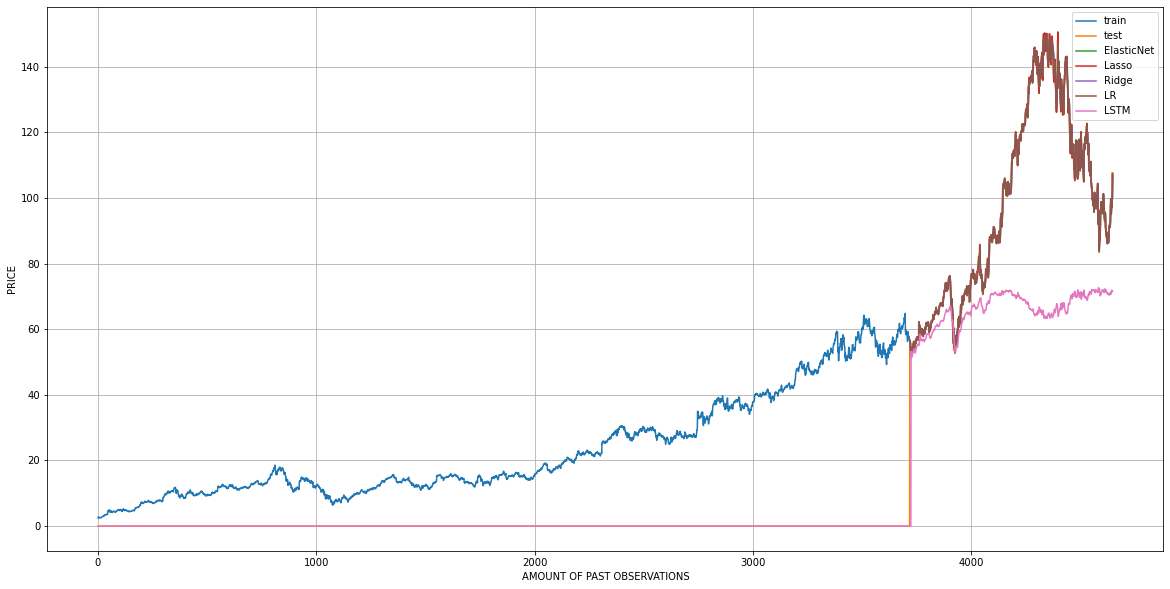

In [387]:
plt.figure(figsize=(20,10))

plt.plot(data_train.values, label = 'train')
plt.plot(data_test_chart, label = 'test')

all_data = []

for name, model in models: 
    data = np.zeros(data.shape[0], dtype=float)
    data.fill(np.nan)
    
    for i in range(1,test_data_size):
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
        
    all_data.append(data)
        
    plt.plot(data , label=name)
    
    
plt.plot(test_predict_inverted_final, label='LSTM')
plt.legend(loc='best')
plt.grid()
plt.xlabel('AMOUNT OF PAST OBSERVATIONS')
plt.ylabel('PRICE')
plt.show()

#### PLOT TEST DATA SECTION AND PREDICTED DATA FOR ALL MODELS

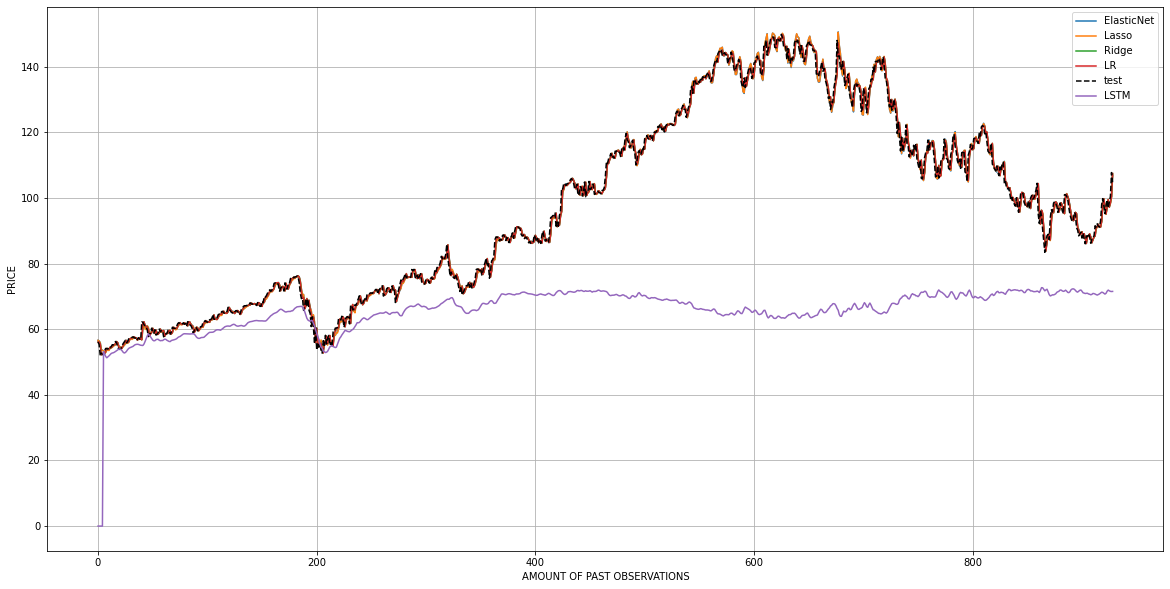

In [388]:
# NARYSOWANIE WYKRESU DLA CZĘŚCI TESTOWEJ NAUCZONYCH MODELI

plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,test_data_size):
        data_chart = data_test.values
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.plot(test_predict_inverted_final[-i:], label='LSTM')

plt.legend(loc='best')
plt.grid()
plt.xlabel('AMOUNT OF PAST OBSERVATIONS')
plt.ylabel('PRICE')
plt.show()

#### PLOTTING LAST 450 OBSERVATIONS AND ITS PREDICTIONS FOR ALL MODELS

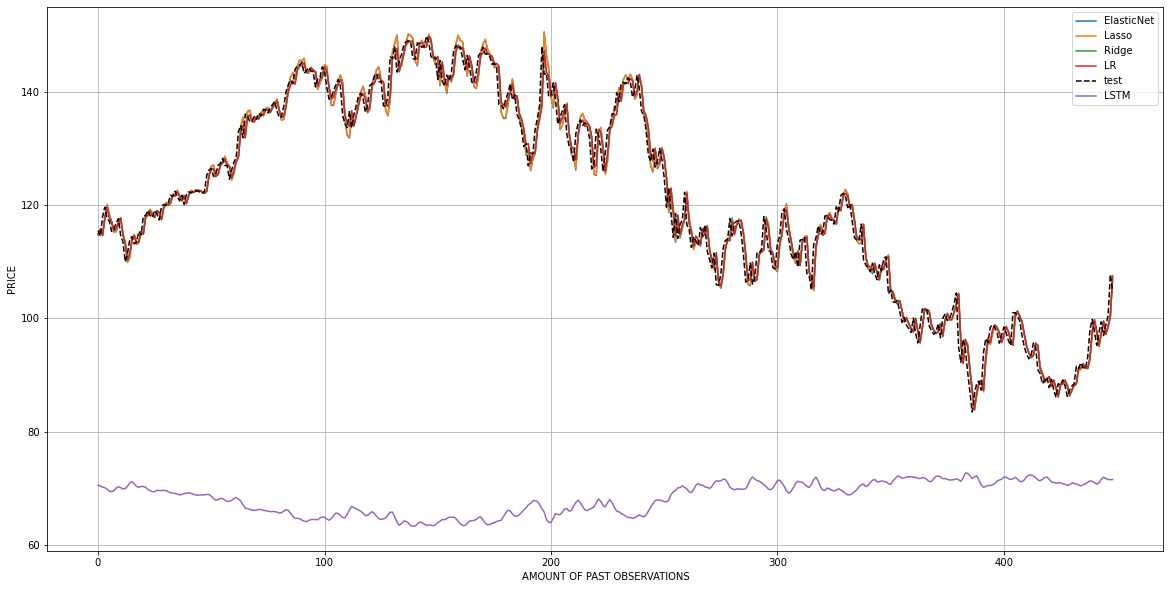

In [389]:
plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,450):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.plot(test_predict_inverted_final[-i:], label='LSTM')

plt.legend(loc='best')
plt.grid()
plt.xlabel('AMOUNT OF PAST OBSERVATIONS')
plt.ylabel('PRICE')
plt.show()

#### PLOTTING LAST 225 OBSERVATIONS AND ITS PREDICTIONS FOR ALL MODELS

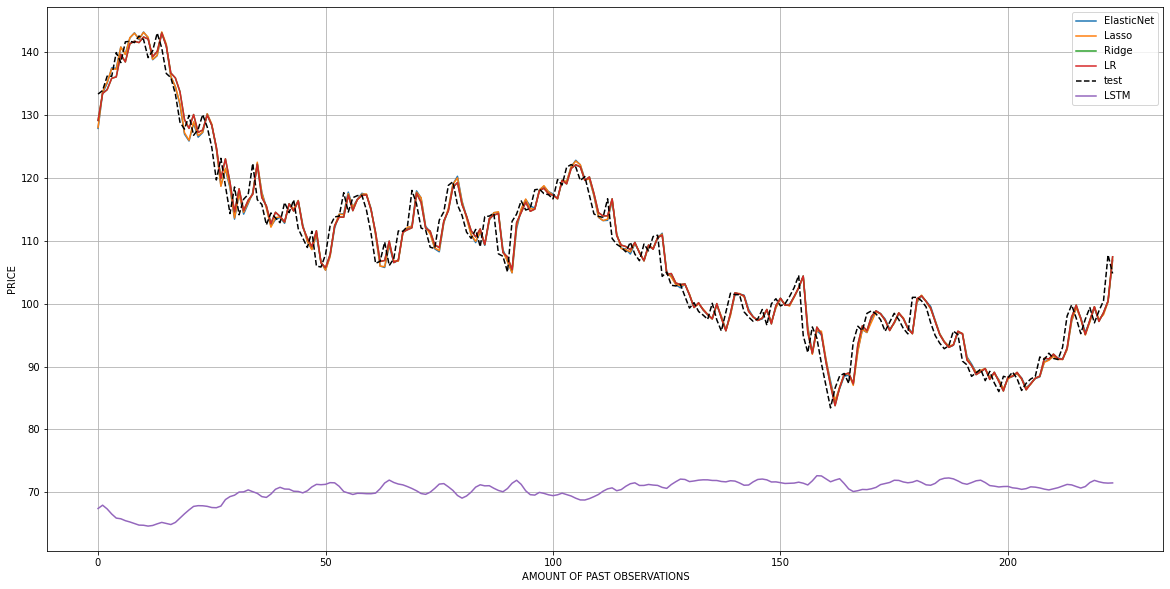

In [390]:
plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,225):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.plot(test_predict_inverted_final[-i:], label='LSTM')

plt.legend(loc='best')
plt.grid()
plt.xlabel('AMOUNT OF PAST OBSERVATIONS')
plt.ylabel('PRICE')
plt.show()

#### PLOTTING LAST 110 OBSERVATIONS AND ITS PREDICTIONS FOR ALL MODELS

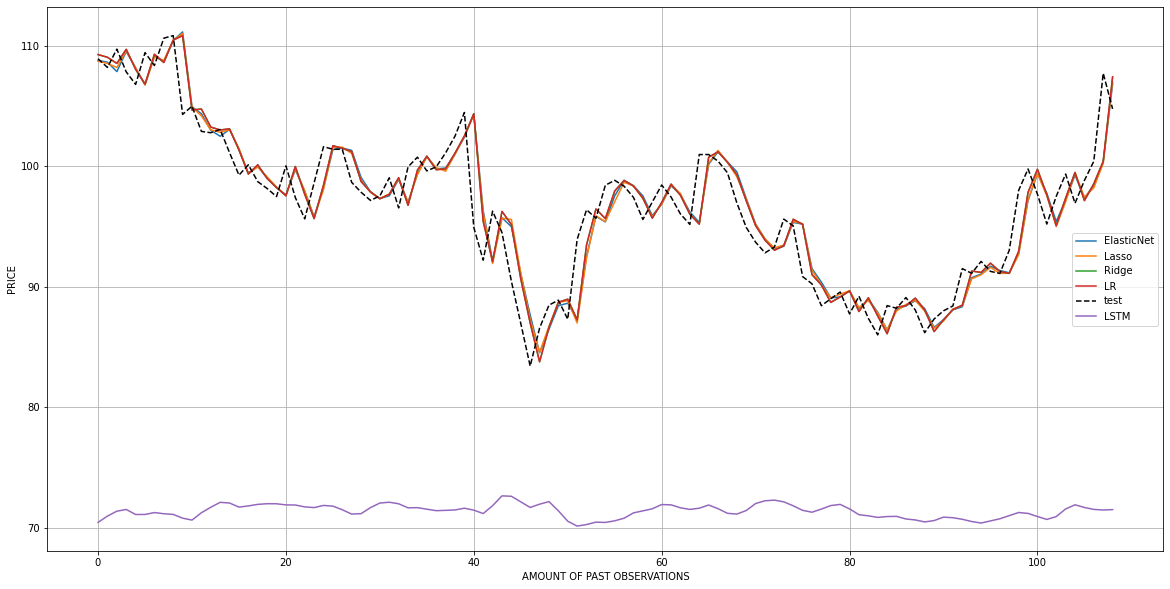

In [391]:
plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,110):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.plot(test_predict_inverted_final[-i:], label='LSTM')

plt.legend(loc='best')
plt.grid()
plt.xlabel('AMOUNT OF PAST OBSERVATIONS')
plt.ylabel('PRICE')
plt.show()

#### PLOTTING LAST 55 OBSERVATIONS AND ITS PREDICTIONS FOR ALL MODELS

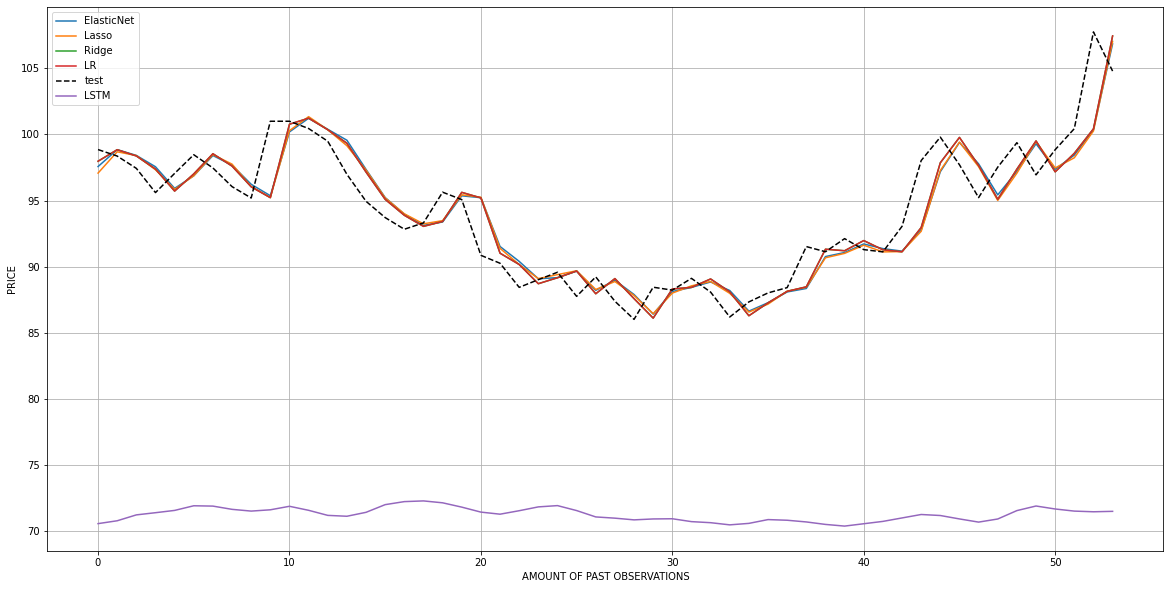

In [392]:
plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,55):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.plot(test_predict_inverted_final[-i:], label='LSTM')

plt.legend(loc='best')
plt.grid()
plt.xlabel('AMOUNT OF PAST OBSERVATIONS')
plt.ylabel('PRICE')
plt.show()

#### PLOTTING LAST 25 OBSERVATIONS AND ITS PREDICTIONS FOR ALL MODELS

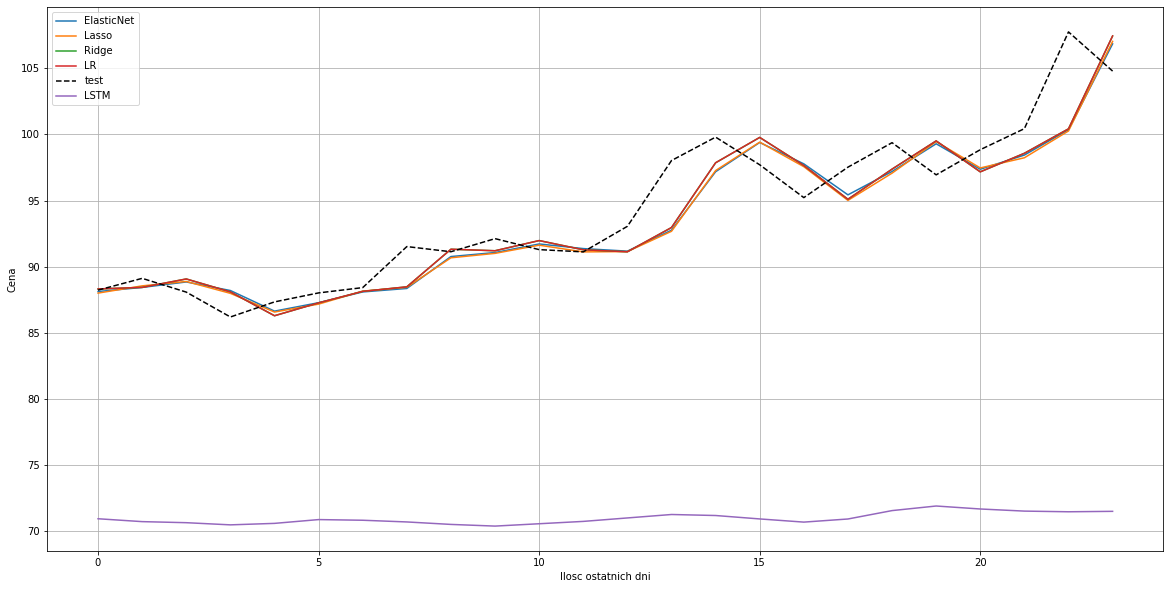

In [393]:
plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,25):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.plot(test_predict_inverted_final[-i:], label='LSTM')

plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

#### PLOTTING LAST 12 OBSERVATIONS AND ITS PREDICTIONS FOR ALL MODELS

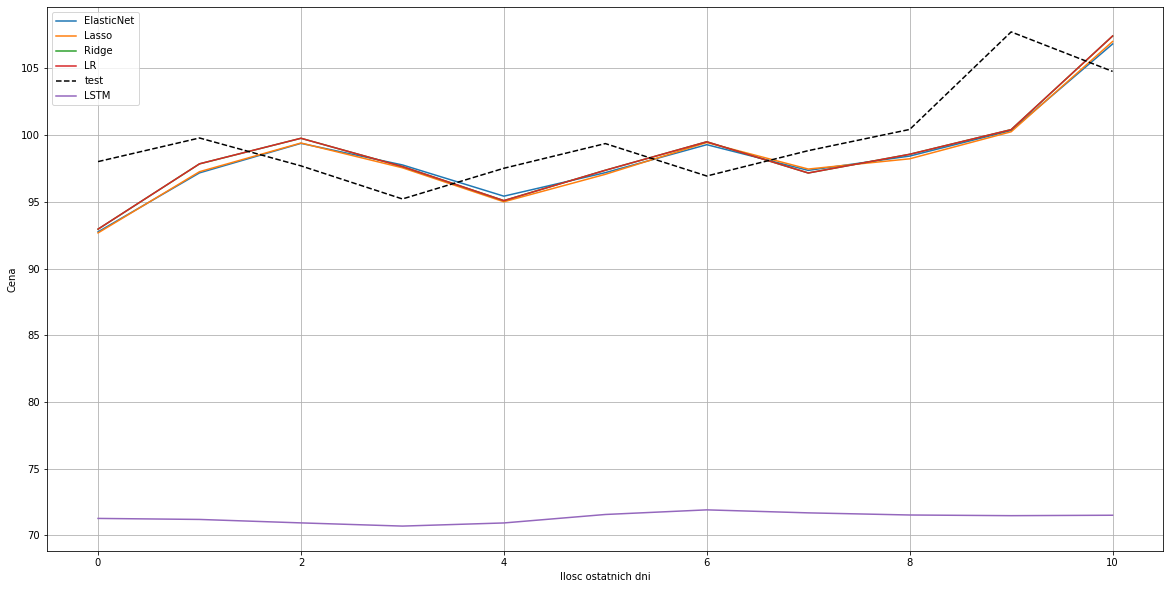

In [394]:
plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,12):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.plot(test_predict_inverted_final[-i:], label='LSTM')

plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

#### CONCLUSION_1: DESPITE THE FACT THAT THE ANALYZED MODELS PREDICT OBSERVATIONS IN SATISFACTORY WAY FOR TEST DATA, IT IS IMPORTANT TO REMEMBER THAT THE MODEL PREDICTS VALUES BASED ON OBSERVATIONS FROM THE PAST, MODEL IS SENSITIVE TO UNEXPECTED EVENTS HAVING LOW PROBABILITY AND INTRODUCING HIGH VOLATILITY TO THE STOCK SO-CALLED "BLACK SWANS"

#### CONCLUSION_2: LSTM NEURAL NETWORK DESPITE BEING A MORE COMPLEX TOOL FOR TIME SERIES PREDICTION THAN OTHER MODELS ACHIEVES RESULTS LESS SATISFACTORY THAN SIMPLER METHODS, WHICH ADDITIONALLY COMPUTE FASTER

#### CONCLUSION_3: TO GET BETTER RESULTS - ESPECIALLY FOR THE LSTM NEURAL NETWORK MODEL ONE SHOULD INCREASE THE TIME_STEP PARAMETER WHICH DEFINES THE NUMBER OF "PAST" OBSERVATIONS ON THE BASIS WHICH WE PREDICT THE "FUTURE" OBSERVATION

#### CONCLUSION_4: SIMPLER METHODS - LINEAR REGRESSION, LASSO REGRESSION, RIDGE REGRESSION, ELASTIC_NET ACHIEVE BETTER RESULTS THAN LSTM NEURAL NETWORK